In [16]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [17]:
import matplotlib.pyplot as plt
is_python ='inline' in matplotlib.get_backend()
if is_python: from IPython import display

In [19]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features = 24)
        self.fc2 = nn.LInear(in_features=24,out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
     
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t 
    

In [20]:
Experience = namedtuple(
           'Experinence',
('state','action','next_state','reward')
)

In [21]:
e = Experience(2,3,1,4)

In [22]:
e

Experinence(state=2, action=3, next_state=1, reward=4)

In [23]:
class ReplayMemory():
    def __init__(self,capacity):
        self.capacity = capacity
        self.memory =[]
        self.push_count = 0
        
    def push(self, experince):
        if len(self.memory)< self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity] = expeience
        self.push_count +=1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size      
        
        

In [24]:
class EpsilonGreedyStratrgy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay =decay
        
    def get_exploration_rate(self,current_step):
        return self.end + (self.start - self.end)*\
               math.exp(-1 * cueernt_step *step.decay)

In [25]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step=0
        self.strategy =strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            return random.randrange(self.num_actions) #explore
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device)#exploit

In [26]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen= None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self, mode='human'):      #render the current state to the screen
        return self.env.render(mode) 
        
    def num_action_available(self):
        return self.env.action_space.n
        
    def take_action(self, action):
        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)

    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else: #end of an episode
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen =s2
            return s2-s1
        
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1)) #pytorch expect
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self,screen):
        screen_height = screen.shape[1]
        
        #strip off top and bottom
        top = int(screen_height*0.4)
        bottom = int(screen_height*0.8)
        screen = screen[:, top:bottom, :]
        return screen
       
    def transform_screen_data(self, screen):
        #conevrt to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32)/255
        screen = torch.from_numpy(screen)
        
        #use torchvision package to compose image transform
        resize = T.Compose([
                    T.ToPILImage()
                    ,T.Resize((40,90))
                    ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) #add a batch simention
    
        

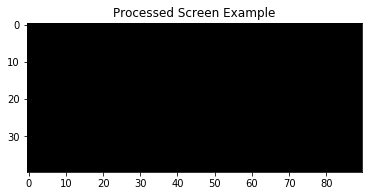

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0),interpolation='none')
plt.title('Processed Screen Example')
plt.show()